## 1. Setup

In [63]:
import dsutils
import numpy as np
from glob import glob
from PIL import Image
from transformers import AutoModel, AutoImageProcessor

In [64]:
DEVICE = 'cuda:6'

ROOT_DIR = '/hdd1/ysyoon/datasets/'
DATASET_NAMES = [
    'aihub-landcover-satellite-all',
    'aihub-satellite-object-cloud',
    'eorssd',
    'isaid',
    'open-earth-map',
    'orsi-sod'
]

## 2. Build

In [65]:
#model_name = '../ckpts/seg_edge_v2/090000/'
model_name = "../ckpts/035000"

In [66]:
image_processor = AutoImageProcessor.from_pretrained("../ckpts/035000", trust_remote_code=True)

In [67]:
model = AutoModel.from_pretrained(model_name, trust_remote_code=True)
_ = model.eval().requires_grad_(False).to(DEVICE)

In [68]:
model_org = AutoModel.from_pretrained('/hdd1/ysyoon/models/seggpt_vit-large/', trust_remote_code=True)
_ = model_org.eval().requires_grad_(False).to(DEVICE)

## 3. Inference

In [69]:
dataset_name = DATASET_NAMES[3]
dataset_name

'isaid'

In [70]:
image_paths = sorted(glob(f'{ROOT_DIR}/{dataset_name}/post/valid/images/*scale-1-0*.png'))

In [71]:
prompt_idx = 10
input_idx = 21

prompt_image_path = image_paths[prompt_idx]
prompt_label_path = prompt_image_path.replace('/images/', '/labels/')
input_image_path = image_paths[input_idx]
input_label_path = input_image_path.replace('/images/', '/labels/')

prompt_image = Image.open(prompt_image_path)
prompt_label = Image.open(prompt_label_path)
input_image = Image.open(input_image_path)
input_label = Image.open(input_label_path)

In [72]:
prompt_label = np.array(prompt_label)
input_label = np.array(input_label)

unique_classes = np.unique(prompt_label)
unique_classes = unique_classes[unique_classes>0]

c = np.random.choice(unique_classes)
print('class: ', c)
assert c > 0

prompt_label = np.where(prompt_label==c, 1, 0)
input_label = np.where(input_label==c, 1, 0)

palette = [[0,0,0], [255,255,255]]
prompt_label = dsutils.segmentation.visualize_label(prompt_label, palette)
input_label = dsutils.segmentation.visualize_label(input_label, palette)

class:  9


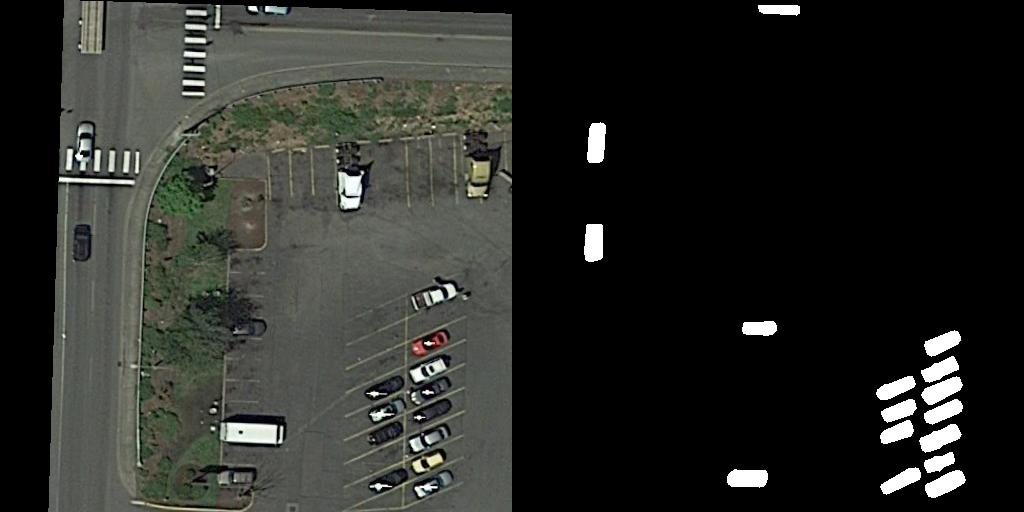

In [73]:
dsutils.image.concat_images_horizontal([prompt_image, prompt_label])

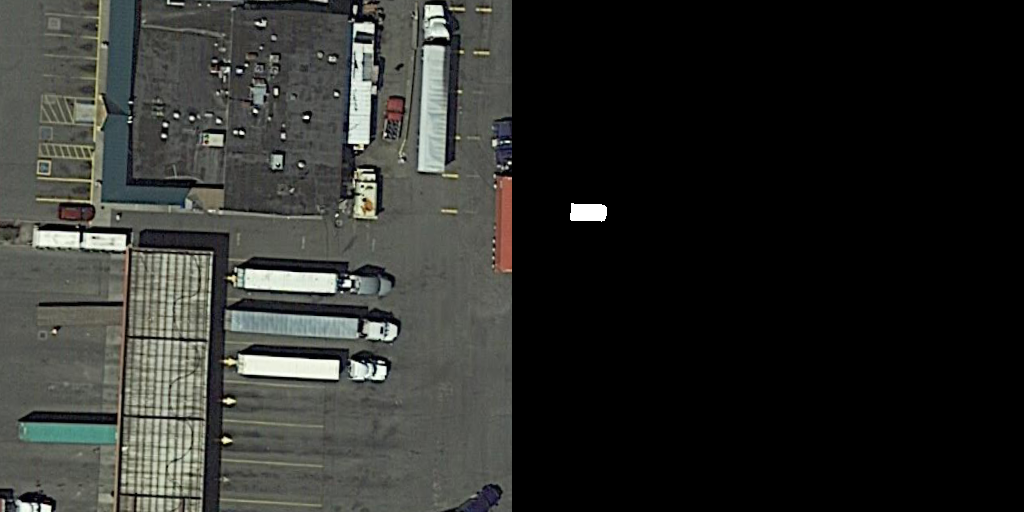

In [74]:
dsutils.image.concat_images_horizontal([input_image, input_label])

In [75]:
# inputs = image_processor(prompt_image, prompt_label, prompt_image, prompt_label, return_tensors='pt')
inputs = image_processor(prompt_image, prompt_label, input_image, input_label, return_tensors='pt')
inputs['masks'] = image_processor.generate_mask(1)
inputs = inputs.to(DEVICE)

In [76]:
inputs['labels'].shape

torch.Size([1, 3, 896, 448])

In [77]:
z = inputs['labels'][0][:,448:,:]

In [78]:
z = z.permute(1,2,0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


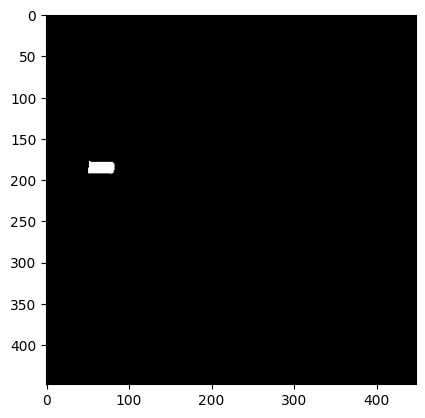

In [79]:
z = z.cpu().numpy()
plt.imshow(z)

In [80]:
ii = inputs['images']

In [81]:
inputs['labels'].shape

torch.Size([1, 3, 896, 448])

In [82]:
inputs['labels'][:,:,448:,:].shape
labels = labels[:,:,448:,:] 

NameError: name 'labels' is not defined

In [83]:
i1 = ii[0,:,:448,:]
i2 = ii[0,:,448:,:]

In [84]:
outputs = model(**inputs)

In [85]:
outputs.preds.shape

torch.Size([1, 3, 896, 448])

In [86]:
outputs = model(**inputs)
pred = outputs.preds[0][:, 448:]
pred = dsutils.image.tensor_to_image(pred).resize((512, 512))

outputs_org = model_org(**inputs)
pred_org = outputs_org.preds[0][:, 448:]
pred_org = dsutils.image.tensor_to_image(pred_org).resize((512, 512))

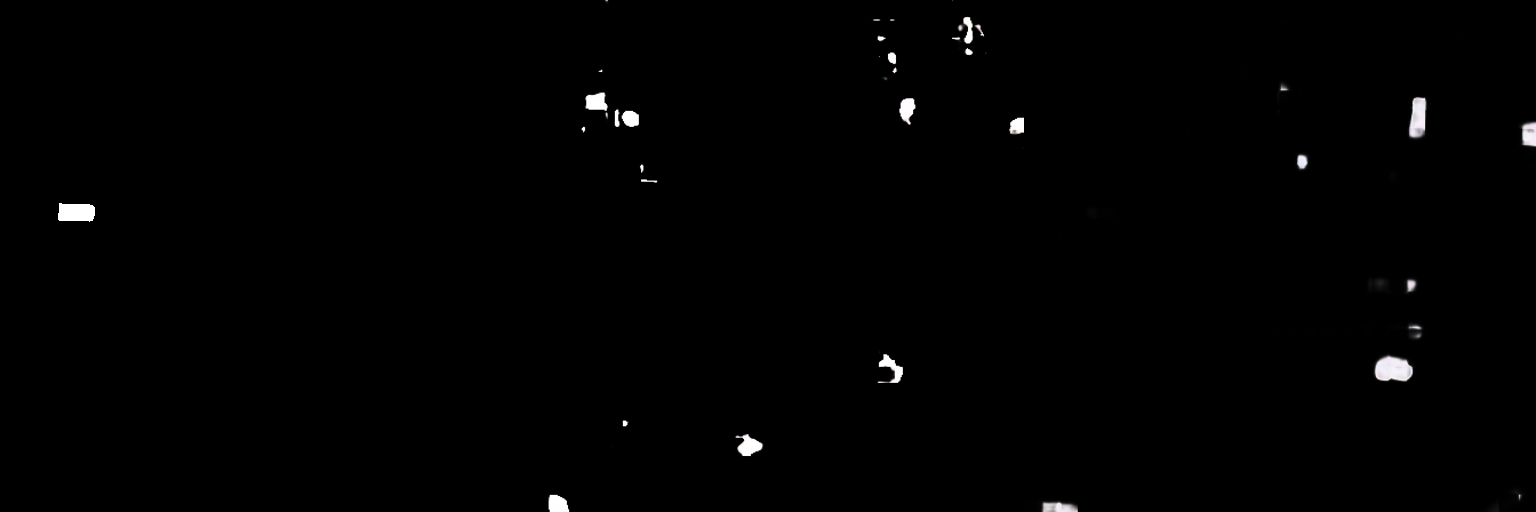

In [87]:
# dsutils.image.concat_images_horizontal([prompt_label, pred, pred_org])
dsutils.image.concat_images_horizontal([input_label, pred, pred_org])

In [88]:
import torch.nn as nn 
import torch
#--- SegGPT 

#--- EdgeNet

class Edge_Net(nn.Module):
    def __init__(self):
        super(Edge_Net, self).__init__()
        #-- edge layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.relu(self.conv1(x))
        x2 = self.relu(self.conv2(x1))
        x3 = self.relu(self.conv3(x2))       
        
        return x1,x2,x3


#---- CombinedModel
class CombinedModel(nn.Module):
    def __init__(self, model1, model2):
        super(CombinedModel, self).__init__()
        self.model1 = model1
        self.model2 = model2
        
        # edge_net freeze
        for param in self.model2.parameters():
            param.requires_grad = False           

    def infer(self, batch):

        #---------
        outputs = self.model1(**batch)

        return outputs
        

In [89]:
# edge ------------------------
edge_net = Edge_Net()
edgenet_path = "./tmp_ckpts/edge_net_epoch_layer_change_10.pt"  # Adjust this path as needed
edge_net.load_state_dict(torch.load(edgenet_path))
edge_net = edge_net.to(DEVICE)

# seg ------------------------
seg_model = AutoModel.from_pretrained(model_name, trust_remote_code=True)
_ = seg_model.eval().requires_grad_(False).to(DEVICE)

# Define model 
combined_model = CombinedModel(seg_model, edge_net)
_ = combined_model.eval().requires_grad_(False).to(DEVICE)

# Load model 
model_path = "../ckpts/seg_edge_v6/segedge_070000"
combined_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [90]:
inputs.labels.shape

torch.Size([1, 3, 896, 448])

In [91]:
aa = inputs['labels'].clone()
aa = aa.permute(0,2,3,1)
aa = aa[0]
aa = aa.cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


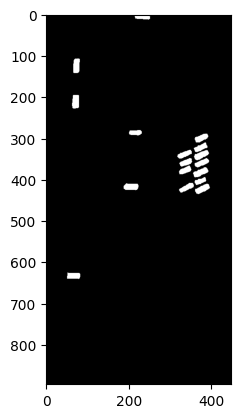

In [92]:
import matplotlib.pyplot as plt
plt.imshow(aa)

In [93]:
inputs['masks'].shape

torch.Size([1, 56, 28])

In [94]:
# inputs = image_processor(prompt_image, prompt_label, prompt_image, prompt_label, return_tensors='pt')
inputs = image_processor(prompt_image, prompt_label, input_image, input_label, return_tensors='pt')
inputs['masks'] = image_processor.generate_mask(1)
inputs = inputs.to(DEVICE)

In [95]:
outputs = combined_model.infer(inputs)
pred = outputs.preds[0]
pred = dsutils.image.tensor_to_image(pred).resize((512, 512))

In [96]:
outputs.preds.shape

torch.Size([1, 3, 896, 448])

In [97]:
qw = outputs.preds[0]
qw = qw.permute(1,2,0)
qw = qw.cpu().numpy()

In [98]:
import matplotlib.pyplot as plt 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


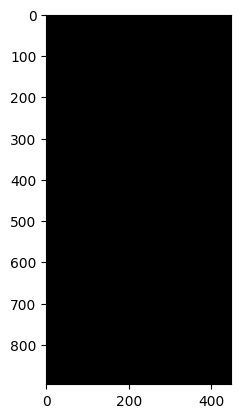

In [124]:
plt.imshow(qw)

In [119]:
np.unique(aa)

array([-2.117904 , -2.0357141, -1.8044444,  2.2489083,  2.4285715,
        2.64     ], dtype=float32)

In [698]:
outputs = combined_model.infer(inputs)

In [699]:
az = inputs
az = az.permute(1,2,0)
az = az.cpu()
az = az.detach().numpy()
plt.imshow(az)

AttributeError: 

In [120]:
outputs = combined_model.infer(inputs)
pred = outputs.preds[0][:, 448:]
pred = dsutils.image.tensor_to_image(pred).resize((512, 512))

outputs_org = model_org(**inputs)
pred_org = outputs_org.preds[0][:, 448:]
pred_org = dsutils.image.tensor_to_image(pred_org).resize((512, 512))

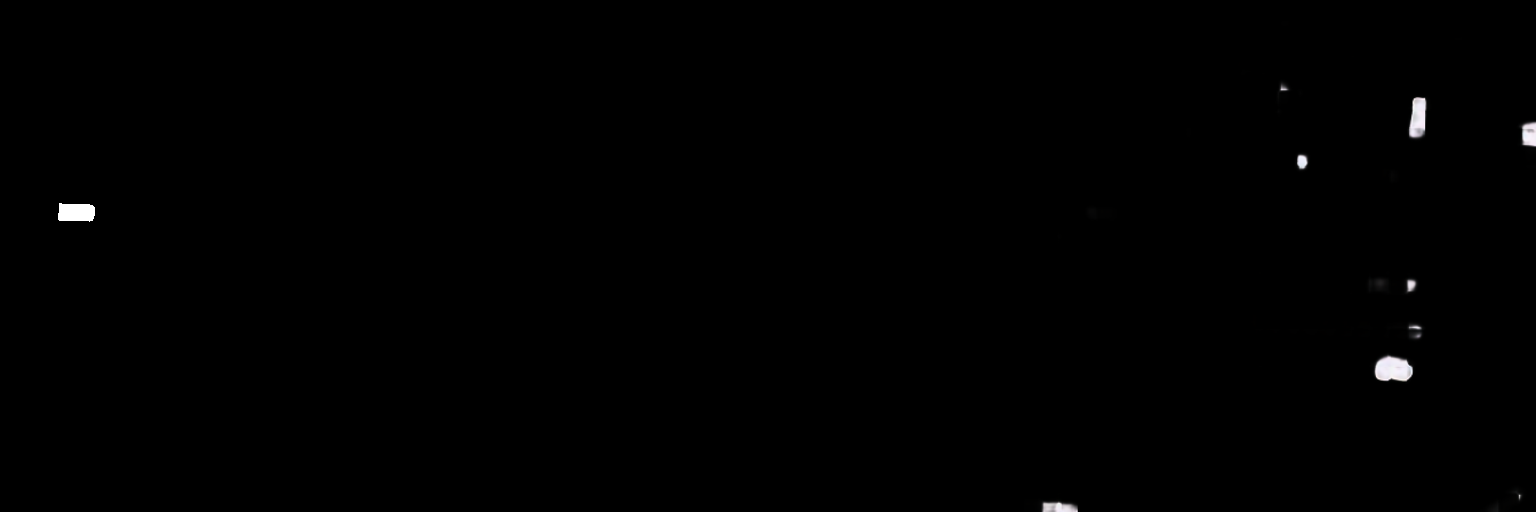

In [123]:
# dsutils.image.concat_images_horizontal([prompt_label, pred, pred_org])
dsutils.image.concat_images_horizontal([input_label, pred, pred_org])